## Advanced NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

## Data 

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

데이터 출처: https://github.com/zalandoresearch/fashion-mnist

### Load Data

In [3]:
train = pd.read_csv('./Assigment/Train.csv')
test = pd.read_csv('./Assigment/Test.csv')

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

In [8]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

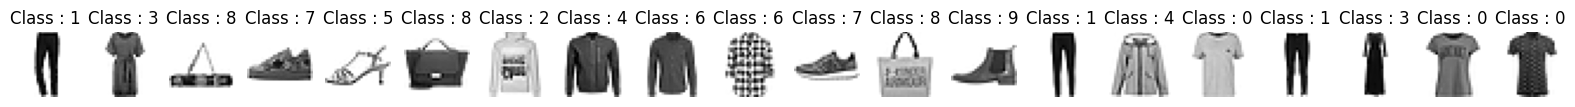

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [10]:
X_test = test.values

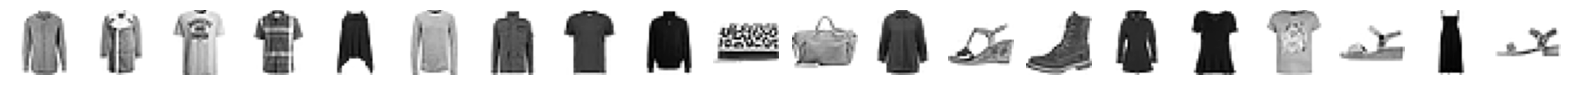

In [11]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

#### Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

### 

In [22]:
DEVICE = torch.device('mps')

print(DEVICE)

mps


In [23]:
BATCH_SIZE = 128
EPOCHS = 15

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [25]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [26]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [27]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [28]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

# Simple_DNN

In [29]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [30]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [31]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.3270, 	Train Accuracy: 56.48 %, 	Val Loss: 0.8218, 	Val Accuracy: 68.42 % 

[EPOCH: 2], 	Train Loss: 0.7183, 	Train Accuracy: 73.69 %, 	Val Loss: 0.6444, 	Val Accuracy: 76.94 % 

[EPOCH: 3], 	Train Loss: 0.6002, 	Train Accuracy: 78.84 %, 	Val Loss: 0.5574, 	Val Accuracy: 80.41 % 

[EPOCH: 4], 	Train Loss: 0.5437, 	Train Accuracy: 80.91 %, 	Val Loss: 0.5257, 	Val Accuracy: 81.46 % 

[EPOCH: 5], 	Train Loss: 0.5123, 	Train Accuracy: 81.98 %, 	Val Loss: 0.5061, 	Val Accuracy: 81.66 % 

[EPOCH: 6], 	Train Loss: 0.4928, 	Train Accuracy: 82.69 %, 	Val Loss: 0.4843, 	Val Accuracy: 82.82 % 

[EPOCH: 7], 	Train Loss: 0.4792, 	Train Accuracy: 83.15 %, 	Val Loss: 0.4643, 	Val Accuracy: 83.60 % 

[EPOCH: 8], 	Train Loss: 0.4685, 	Train Accuracy: 83.63 %, 	Val Loss: 0.4661, 	Val Accuracy: 83.90 % 

[EPOCH: 9], 	Train Loss: 0.4596, 	Train Accuracy: 83.86 %, 	Val Loss: 0.4786, 	Val Accuracy: 83.12 % 

[EPOCH: 10], 	Train Loss: 0.4529, 	Train Accuracy: 84.16 %, 	Val Loss: 0.

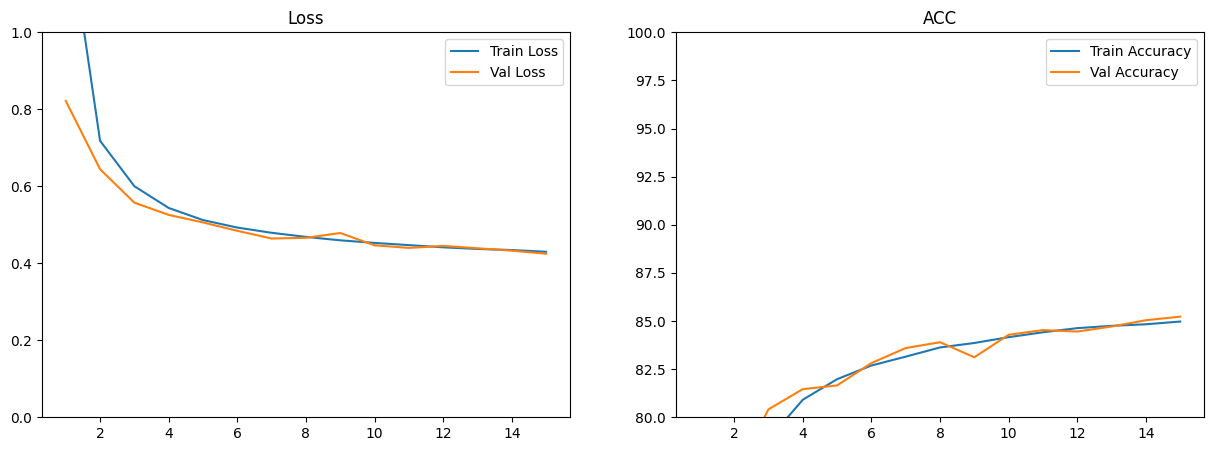

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Activation Function

In [33]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [34]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [35]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.8955, 	Train Accuracy: 38.17 %, 	Val Loss: 1.1371, 	Val Accuracy: 58.20 % 

[EPOCH: 2], 	Train Loss: 0.9014, 	Train Accuracy: 64.94 %, 	Val Loss: 0.7650, 	Val Accuracy: 70.71 % 

[EPOCH: 3], 	Train Loss: 0.7133, 	Train Accuracy: 73.57 %, 	Val Loss: 0.6929, 	Val Accuracy: 73.82 % 

[EPOCH: 4], 	Train Loss: 0.6326, 	Train Accuracy: 77.49 %, 	Val Loss: 0.5927, 	Val Accuracy: 79.34 % 

[EPOCH: 5], 	Train Loss: 0.5800, 	Train Accuracy: 79.74 %, 	Val Loss: 0.5506, 	Val Accuracy: 80.77 % 

[EPOCH: 6], 	Train Loss: 0.5414, 	Train Accuracy: 81.09 %, 	Val Loss: 0.5147, 	Val Accuracy: 81.71 % 

[EPOCH: 7], 	Train Loss: 0.5147, 	Train Accuracy: 81.89 %, 	Val Loss: 0.4879, 	Val Accuracy: 83.02 % 

[EPOCH: 8], 	Train Loss: 0.4934, 	Train Accuracy: 82.62 %, 	Val Loss: 0.4750, 	Val Accuracy: 83.24 % 

[EPOCH: 9], 	Train Loss: 0.4753, 	Train Accuracy: 83.39 %, 	Val Loss: 0.4699, 	Val Accuracy: 83.13 % 

[EPOCH: 10], 	Train Loss: 0.4613, 	Train Accuracy: 83.84 %, 	Val Loss: 0.

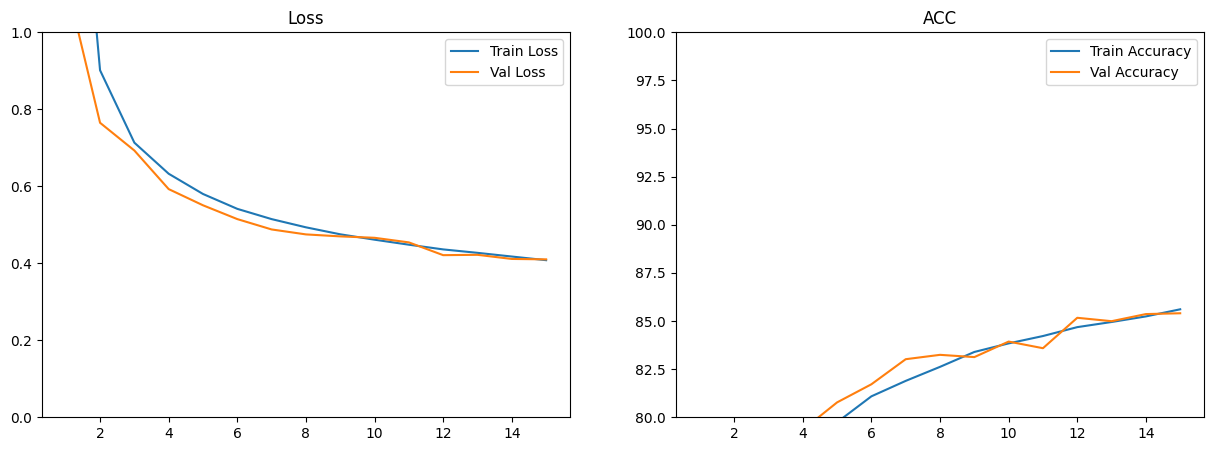

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Weight Initialization

In [39]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [40]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [41]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.9866, 	Train Accuracy: 68.07 %, 	Val Loss: 0.6267, 	Val Accuracy: 77.97 % 

[EPOCH: 2], 	Train Loss: 0.5646, 	Train Accuracy: 80.35 %, 	Val Loss: 0.5018, 	Val Accuracy: 82.89 % 

[EPOCH: 3], 	Train Loss: 0.4965, 	Train Accuracy: 82.52 %, 	Val Loss: 0.4629, 	Val Accuracy: 84.07 % 

[EPOCH: 4], 	Train Loss: 0.4618, 	Train Accuracy: 83.73 %, 	Val Loss: 0.4361, 	Val Accuracy: 85.08 % 

[EPOCH: 5], 	Train Loss: 0.4377, 	Train Accuracy: 84.55 %, 	Val Loss: 0.4144, 	Val Accuracy: 85.48 % 

[EPOCH: 6], 	Train Loss: 0.4207, 	Train Accuracy: 85.13 %, 	Val Loss: 0.4094, 	Val Accuracy: 85.66 % 

[EPOCH: 7], 	Train Loss: 0.4043, 	Train Accuracy: 85.67 %, 	Val Loss: 0.4002, 	Val Accuracy: 85.98 % 

[EPOCH: 8], 	Train Loss: 0.3921, 	Train Accuracy: 86.03 %, 	Val Loss: 0.4189, 	Val Accuracy: 85.30 % 

[EPOCH: 9], 	Train Loss: 0.3814, 	Train Accuracy: 86.48 %, 	Val Loss: 0.3836, 	Val Accuracy: 86.62 % 

[EPOCH: 10], 	Train Loss: 0.3706, 	Train Accuracy: 86.81 %, 	Val Loss: 0.

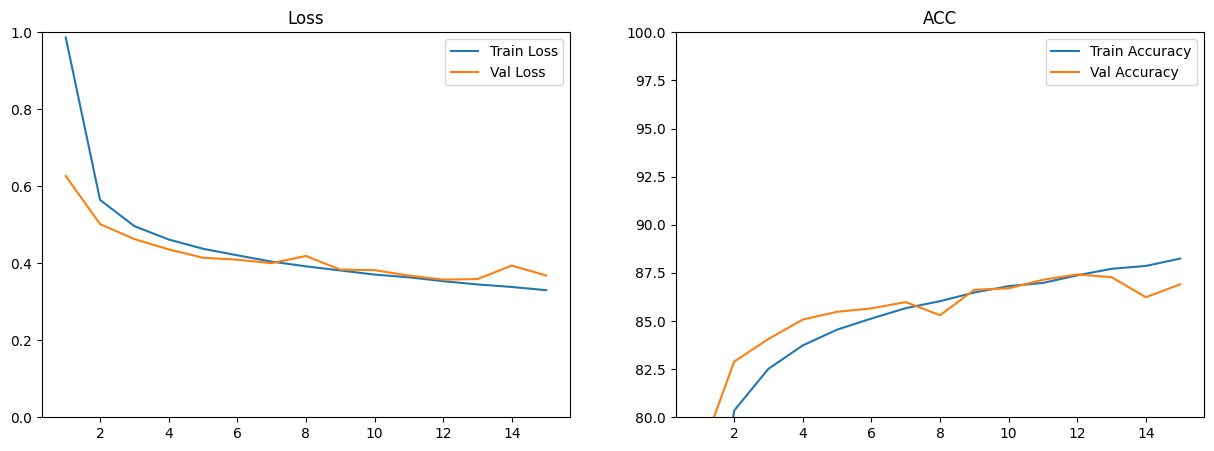

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Batch Normalization

In [43]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [44]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [45]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.8235, 	Train Accuracy: 75.17 %, 	Val Loss: 0.5121, 	Val Accuracy: 82.83 % 

[EPOCH: 2], 	Train Loss: 0.4737, 	Train Accuracy: 83.71 %, 	Val Loss: 0.4204, 	Val Accuracy: 84.94 % 

[EPOCH: 3], 	Train Loss: 0.4061, 	Train Accuracy: 85.79 %, 	Val Loss: 0.3822, 	Val Accuracy: 86.28 % 

[EPOCH: 4], 	Train Loss: 0.3696, 	Train Accuracy: 86.86 %, 	Val Loss: 0.3574, 	Val Accuracy: 87.02 % 

[EPOCH: 5], 	Train Loss: 0.3424, 	Train Accuracy: 87.75 %, 	Val Loss: 0.3513, 	Val Accuracy: 87.08 % 

[EPOCH: 6], 	Train Loss: 0.3209, 	Train Accuracy: 88.58 %, 	Val Loss: 0.3351, 	Val Accuracy: 87.90 % 

[EPOCH: 7], 	Train Loss: 0.3016, 	Train Accuracy: 89.15 %, 	Val Loss: 0.3282, 	Val Accuracy: 87.79 % 

[EPOCH: 8], 	Train Loss: 0.2833, 	Train Accuracy: 89.81 %, 	Val Loss: 0.3223, 	Val Accuracy: 88.21 % 

[EPOCH: 9], 	Train Loss: 0.2678, 	Train Accuracy: 90.54 %, 	Val Loss: 0.3290, 	Val Accuracy: 87.84 % 

[EPOCH: 10], 	Train Loss: 0.2540, 	Train Accuracy: 91.03 %, 	Val Loss: 0.

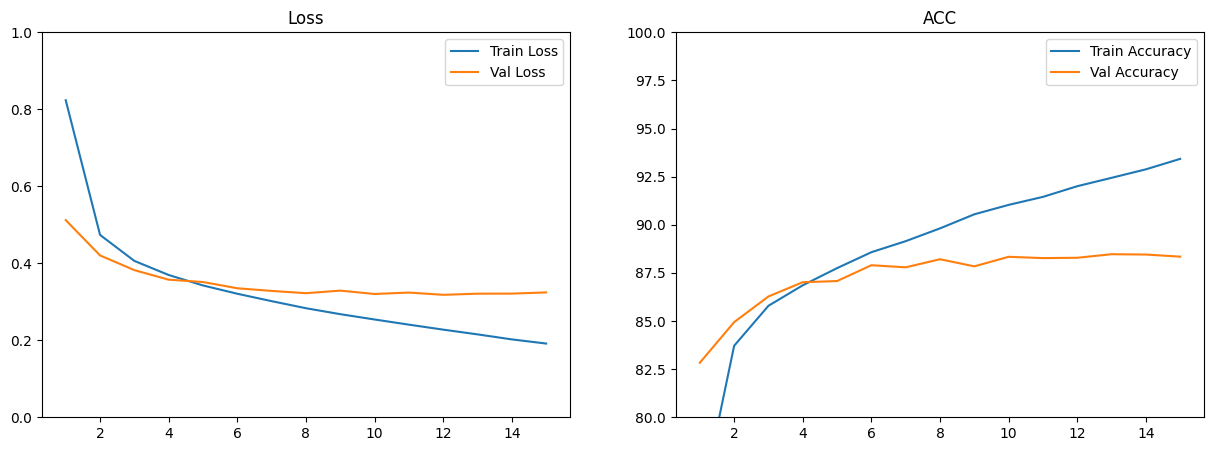

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Optimization

In [47]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [48]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [49]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.4912, 	Train Accuracy: 81.91 %, 	Val Loss: 0.4176, 	Val Accuracy: 84.69 % 

[EPOCH: 2], 	Train Loss: 0.3730, 	Train Accuracy: 86.42 %, 	Val Loss: 0.3575, 	Val Accuracy: 87.04 % 

[EPOCH: 3], 	Train Loss: 0.3326, 	Train Accuracy: 87.55 %, 	Val Loss: 0.3408, 	Val Accuracy: 87.36 % 

[EPOCH: 4], 	Train Loss: 0.3045, 	Train Accuracy: 88.76 %, 	Val Loss: 0.4164, 	Val Accuracy: 85.09 % 

[EPOCH: 5], 	Train Loss: 0.2794, 	Train Accuracy: 89.49 %, 	Val Loss: 0.3797, 	Val Accuracy: 86.39 % 

[EPOCH: 6], 	Train Loss: 0.2627, 	Train Accuracy: 90.25 %, 	Val Loss: 0.3283, 	Val Accuracy: 88.20 % 

[EPOCH: 7], 	Train Loss: 0.2454, 	Train Accuracy: 90.76 %, 	Val Loss: 0.3079, 	Val Accuracy: 89.41 % 

[EPOCH: 8], 	Train Loss: 0.2300, 	Train Accuracy: 91.37 %, 	Val Loss: 0.3174, 	Val Accuracy: 88.76 % 

[EPOCH: 9], 	Train Loss: 0.2201, 	Train Accuracy: 91.70 %, 	Val Loss: 0.3031, 	Val Accuracy: 89.34 % 

[EPOCH: 10], 	Train Loss: 0.2050, 	Train Accuracy: 92.32 %, 	Val Loss: 0.

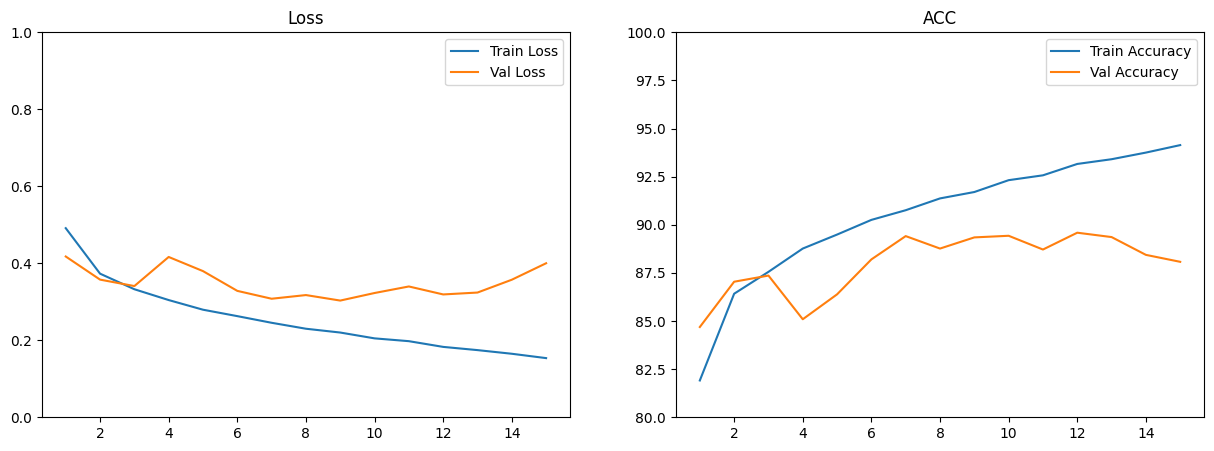

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Dropout

In [51]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [52]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [53]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5283, 	Train Accuracy: 81.00 %, 	Val Loss: 0.4426, 	Val Accuracy: 84.70 % 

[EPOCH: 2], 	Train Loss: 0.4120, 	Train Accuracy: 85.00 %, 	Val Loss: 0.3673, 	Val Accuracy: 86.69 % 

[EPOCH: 3], 	Train Loss: 0.3711, 	Train Accuracy: 86.53 %, 	Val Loss: 0.3277, 	Val Accuracy: 87.79 % 

[EPOCH: 4], 	Train Loss: 0.3415, 	Train Accuracy: 87.49 %, 	Val Loss: 0.3069, 	Val Accuracy: 88.85 % 

[EPOCH: 5], 	Train Loss: 0.3268, 	Train Accuracy: 88.04 %, 	Val Loss: 0.3056, 	Val Accuracy: 88.67 % 

[EPOCH: 6], 	Train Loss: 0.3090, 	Train Accuracy: 88.49 %, 	Val Loss: 0.3156, 	Val Accuracy: 88.37 % 

[EPOCH: 7], 	Train Loss: 0.2957, 	Train Accuracy: 89.03 %, 	Val Loss: 0.3181, 	Val Accuracy: 88.31 % 

[EPOCH: 8], 	Train Loss: 0.2831, 	Train Accuracy: 89.46 %, 	Val Loss: 0.3390, 	Val Accuracy: 88.08 % 

[EPOCH: 9], 	Train Loss: 0.2736, 	Train Accuracy: 89.74 %, 	Val Loss: 0.3039, 	Val Accuracy: 89.13 % 

[EPOCH: 10], 	Train Loss: 0.2614, 	Train Accuracy: 90.37 %, 	Val Loss: 0.

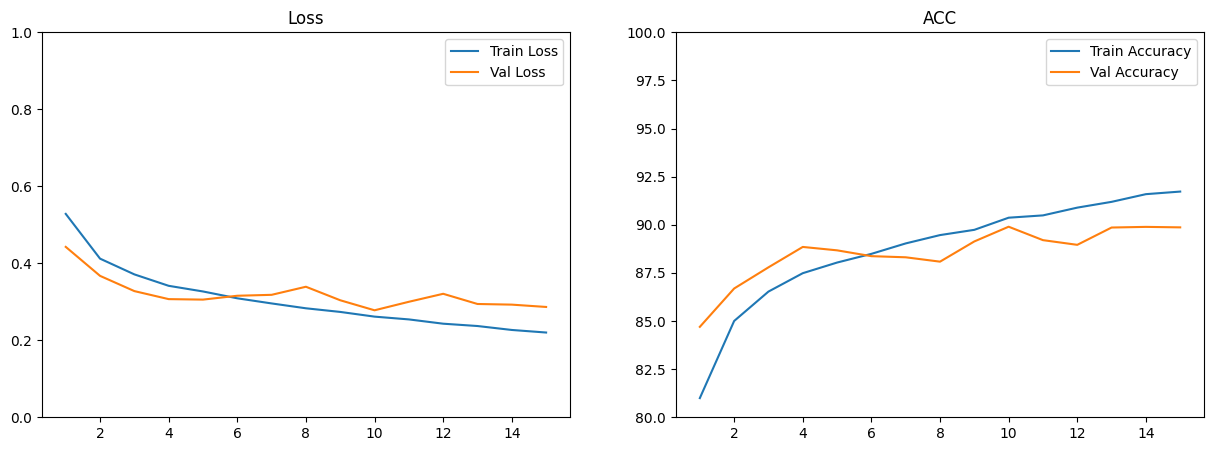

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# Regularization

In [55]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [56]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [57]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.6394, 	Train Accuracy: 77.04 %, 	Val Loss: 0.5615, 	Val Accuracy: 80.46 % 

[EPOCH: 2], 	Train Loss: 0.6095, 	Train Accuracy: 78.41 %, 	Val Loss: 0.6788, 	Val Accuracy: 75.12 % 

[EPOCH: 3], 	Train Loss: 0.5981, 	Train Accuracy: 78.81 %, 	Val Loss: 0.5905, 	Val Accuracy: 76.26 % 

[EPOCH: 4], 	Train Loss: 0.5951, 	Train Accuracy: 79.07 %, 	Val Loss: 0.5591, 	Val Accuracy: 80.21 % 

[EPOCH: 5], 	Train Loss: 0.5890, 	Train Accuracy: 79.13 %, 	Val Loss: 0.6526, 	Val Accuracy: 77.08 % 

[EPOCH: 6], 	Train Loss: 0.5870, 	Train Accuracy: 79.34 %, 	Val Loss: 0.6303, 	Val Accuracy: 77.07 % 

[EPOCH: 7], 	Train Loss: 0.5936, 	Train Accuracy: 79.14 %, 	Val Loss: 0.5297, 	Val Accuracy: 80.44 % 

[EPOCH: 8], 	Train Loss: 0.5934, 	Train Accuracy: 79.44 %, 	Val Loss: 0.5866, 	Val Accuracy: 80.14 % 

[EPOCH: 9], 	Train Loss: 0.5855, 	Train Accuracy: 79.37 %, 	Val Loss: 0.5858, 	Val Accuracy: 79.46 % 

[EPOCH: 10], 	Train Loss: 0.5894, 	Train Accuracy: 79.37 %, 	Val Loss: 0.

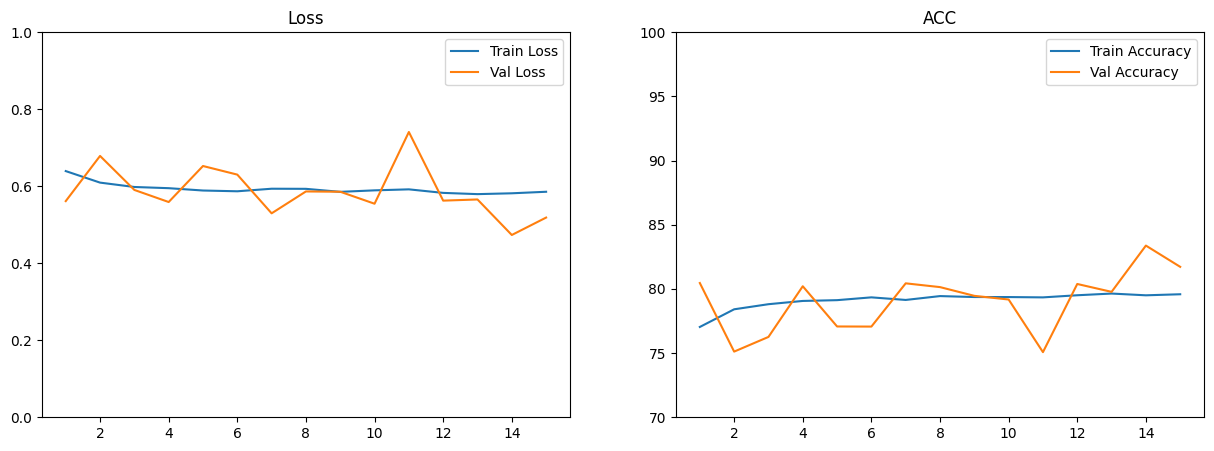

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# 제출

In [59]:
BATCH_SIZE = 128
EPOCHS = 100

In [60]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [61]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [62]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5287, 	Train Accuracy: 80.80 %, 	Val Loss: 0.3950, 	Val Accuracy: 85.85 % 

[EPOCH: 2], 	Train Loss: 0.4110, 	Train Accuracy: 85.16 %, 	Val Loss: 0.3649, 	Val Accuracy: 86.76 % 

[EPOCH: 3], 	Train Loss: 0.3693, 	Train Accuracy: 86.46 %, 	Val Loss: 0.3506, 	Val Accuracy: 87.32 % 

[EPOCH: 4], 	Train Loss: 0.3471, 	Train Accuracy: 87.18 %, 	Val Loss: 0.3266, 	Val Accuracy: 87.75 % 

[EPOCH: 5], 	Train Loss: 0.3297, 	Train Accuracy: 87.88 %, 	Val Loss: 0.3157, 	Val Accuracy: 88.37 % 

[EPOCH: 6], 	Train Loss: 0.3104, 	Train Accuracy: 88.56 %, 	Val Loss: 0.3085, 	Val Accuracy: 88.90 % 

[EPOCH: 7], 	Train Loss: 0.2970, 	Train Accuracy: 88.85 %, 	Val Loss: 0.3201, 	Val Accuracy: 88.22 % 

[EPOCH: 8], 	Train Loss: 0.2854, 	Train Accuracy: 89.27 %, 	Val Loss: 0.3230, 	Val Accuracy: 88.35 % 

[EPOCH: 9], 	Train Loss: 0.2746, 	Train Accuracy: 89.75 %, 	Val Loss: 0.3103, 	Val Accuracy: 88.82 % 

[EPOCH: 10], 	Train Loss: 0.2678, 	Train Accuracy: 90.09 %, 	Val Loss: 0.

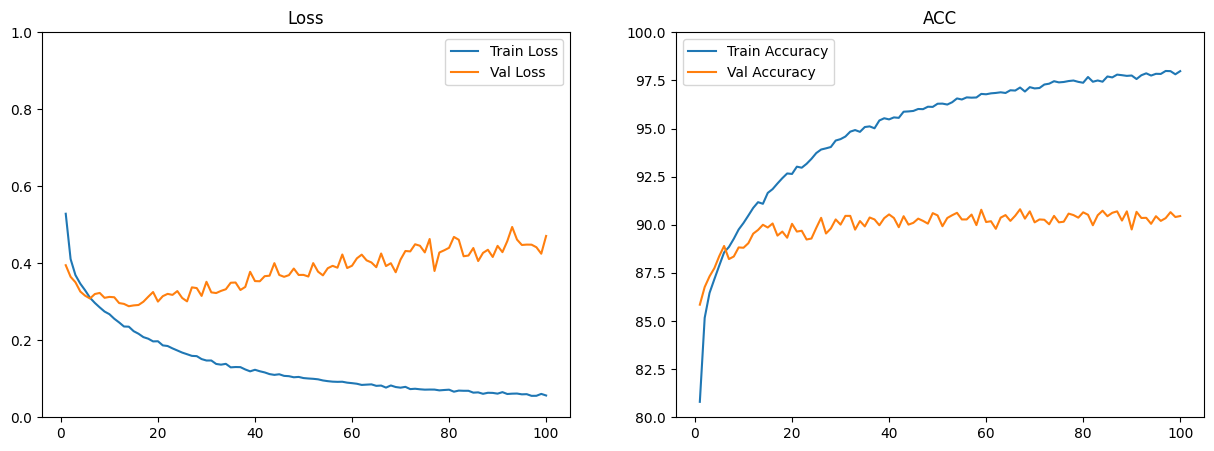

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()